# Machine Learning (Random Forest , Pipelines and Serialization)

### Load Processed Data

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from datetime import datetime
from datetime import timedelta


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv("/content/drive/MyDrive/Project 6 Pharmaceutical stores sale prediction using Time series/processed_train.csv", parse_dates=["Date"])
test = pd.read_csv("/content/drive/MyDrive/Project 6 Pharmaceutical stores sale prediction using Time series/processed_test.csv", parse_dates=["Date"])


In [4]:
# Filter Open Days
train = train[train["Open"]==1].sort_values("Date")                       # remove closed days
test = test[test["Open"]==1].sort_values("Date").reset_index(drop=True)

## Train/Validation Split (Time-based)

In [5]:
# Ensure data is sorted by date
train = train.sort_values("Date").reset_index(drop=True)

# 80% split index
split_idx = int(len(train) * 0.8)

# Split
train_part = train.iloc[:split_idx]
val = train.iloc[split_idx:]

train = train_part

print("Train shape:", train.shape)
print("Validation shape:", val.shape)

Train shape: (675513, 28)
Validation shape: (168879, 28)


In [6]:
# Features/Target

drop_cols = ["Sales","Date","Customers","Id"]

x_train = train.drop(columns=drop_cols, errors="ignore")
y_train = train["Sales"]

x_val = val.drop(columns=drop_cols, errors="ignore")
y_val = val["Sales"]

x_test = test.drop(columns=drop_cols, errors="ignore")


### Preprocessing Pipeline

In [7]:
num_cols = x_train.select_dtypes(include=np.number).columns
cat_cols = x_train.select_dtypes(exclude=np.number).columns

num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

prep = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])


### Train Model

In [8]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline([
    ("prep", prep),
    ("rf", rf)
])

pipe.fit(x_train,y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Store', 'DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'Year...
       'IsHoliday', 'DaysBeforeHoliday', 'DaysAfterHoliday',
       'CompetitionOpenMonths'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['StoreType', 'Assortment', 'PromoInterval', 'MonthPart'], dtype='object'))])),
                ('rf',
                 RandomForestRegressor(max_depth=20, n_estimators=300,
                                       n_jobs=-1, random_state=42))])

### Feature Importance

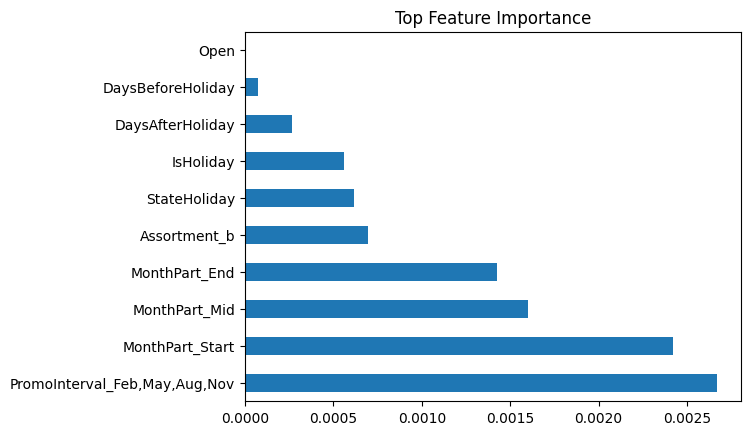

In [9]:
rf_model = pipe.named_steps["rf"]
preprocessor = pipe.named_steps["prep"]
num_features = num_cols.tolist()
cat_features = preprocessor.named_transformers_["cat"] \
    .named_steps["ohe"] \
    .get_feature_names_out(cat_cols)
feature_names = num_features + list(cat_features)

importances = rf_model.feature_importances_

feat_imp = pd.Series(importances, index=feature_names)
feat_imp = feat_imp.sort_values(ascending=False)

feat_imp.head(10)
feat_imp.tail(10).plot(kind="barh", title="Top Feature Importance")
plt.show()


### Validation Score (Evaluation)

In [18]:
val_pred = pipe.predict(x_val)
print("Validation MAE:", mean_absolute_error(y_val, val_pred))

# RMSE
rf_rmse = np.sqrt(
    mean_squared_error(y_val, val_pred)
)

# MAPE
rf_mape = mean_absolute_percentage_error(
    y_val, val_pred
)

print("RF RMSE:", rf_rmse)
print("RF MAPE:", rf_mape)

Validation MAE: 870.2854206367127
RF RMSE: 1270.2795621241698
RF MAPE: 612188069957319.5


### Predict Test Set

In [19]:
test["PredictedSales"] = pipe.predict(x_test)

test[["Id","PredictedSales"]].head()


,Id,PredictedSales
0,41088,6517.754500
1,40523,5746.552871
2,40522,6980.448478
3,40521,5969.810048
4,40520,7056.622698


### Forecast next 42-Day

In [20]:
expected_features = x_train.columns
print(len(expected_features))
expected_features

last_date = train["Date"].max()

future_dates = pd.date_range(last_date+timedelta(days=1), periods=42, freq="D")

last_features = x_train.iloc[-1]

future = pd.DataFrame([last_features.values] * len(future_dates),
                      columns=expected_features)

future["Date"] = future_dates

x_future = future.drop(columns=["Date"], errors="ignore")

future["PredictedSales"] = pipe.predict(x_future)

future.head()

25


,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,...,Day,Weekday,IsWeekend,MonthPart,IsHoliday,DaysBeforeHoliday,DaysAfterHoliday,CompetitionOpenMonths,Date,PredictedSales
0,497,5,1,1,0.0,0,a,c,1610.0,NaN,...,30,4,0,End,0,0.0,0.0,0.0,2015-01-31,11139.00123
1,497,5,1,1,0.0,0,a,c,1610.0,NaN,...,30,4,0,End,0,0.0,0.0,0.0,2015-02-01,11139.00123
2,497,5,1,1,0.0,0,a,c,1610.0,NaN,...,30,4,0,End,0,0.0,0.0,0.0,2015-02-02,11139.00123
3,497,5,1,1,0.0,0,a,c,1610.0,NaN,...,30,4,0,End,0,0.0,0.0,0.0,2015-02-03,11139.00123
4,497,5,1,1,0.0,0,a,c,1610.0,NaN,...,30,4,0,End,0,0.0,0.0,0.0,2015-02-04,11139.00123


### Serialize Model

In [13]:
timestamp = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")

filename = f"/content/drive/MyDrive/Project 6 Pharmaceutical stores sale prediction using Time series/rf_pipeline_{timestamp}.pkl"

joblib.dump(pipe, filename)

print(f"Model saved as {filename}")


Model saved as /content/drive/MyDrive/Project 6 Pharmaceutical stores sale prediction using Time series/rf_pipeline_15-02-2026-12-33-47.pkl
